In [7]:
from torch._C import import_ir_module
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import PIL
from PIL import Image
import zipfile
import io
import os, random
from torch.utils.data import DataLoader, Dataset
from torch import optim
from torchvision.io import read_image
from torchvision import datasets, transforms
import matplotlib as mplib
import matplotlib.pyplot as plt
import cv2
from torchvision.io.image import ImageReadMode
import shutil

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Drivers_License_Image_Library.zip to Drivers_License_Image_Library.zip


In [11]:
data = zipfile.ZipFile(io.BytesIO(uploaded['Drivers_License_Image_Library.zip']), 'r')
data.extractall()
#os.remove('/content/Drivers_License_Image_Library.zip')

In [ ]:
#shutil.rmtree('/content/Drivers_License_Image_Library',ignore_errors=True)

In [12]:
data.printdir()

File Name                                             Modified             Size
Drivers_License_Image_Library/01_Training_Data/ 2022-07-13 00:58:12            0
Drivers_License_Image_Library/01_Training_Data/img001.jpg 2022-07-10 12:27:26        49440
Drivers_License_Image_Library/01_Training_Data/img002.jpg 2022-07-10 12:27:26        56684
Drivers_License_Image_Library/01_Training_Data/img003.jpg 2022-07-10 12:27:26        50111
Drivers_License_Image_Library/01_Training_Data/img004.jpg 2022-07-10 12:27:26        58455
Drivers_License_Image_Library/01_Training_Data/img005.jpg 2022-07-10 12:27:26        44635
Drivers_License_Image_Library/01_Training_Data/img006.jpg 2022-07-10 12:27:26        34075
Drivers_License_Image_Library/01_Training_Data/img007.jpg 2022-07-10 12:27:26        43366
Drivers_License_Image_Library/01_Training_Data/img008.jpg 2022-07-10 12:27:26        40819
Drivers_License_Image_Library/01_Training_Data/img009.jpg 2022-07-10 12:27:26        41080
Drivers_License_Imag

In [13]:
print(os.getcwd())

/content


In [14]:
print(os.listdir('/content'))

['.config', 'Drivers_License_Image_Library', 'Drivers_License_Image_Library.zip', 'sample_data']


In [15]:
print(os.listdir('/content/Drivers_License_Image_Library'))

['02_Test_Data', '01_Training_Data']


In [16]:
print(os.listdir('/content/Drivers_License_Image_Library/01_Training_Data'))

['img029.jpg', 'img017.jpg', 'img036.jpg', 'img031.jpg', 'img006.jpg', 'img019.jpg', 'img028.jpg', 'img005.jpg', 'img040.jpg', 'img020.jpg', 'img046.jpg', 'img035.jpg', 'img030.jpg', 'img034.jpg', 'img023.jpg', 'img012.jpg', 'img008.jpg', 'img007.jpg', 'img033.jpg', 'img001.jpg', 'img045.jpg', 'img050.jpg', 'img026.jpg', 'img003.jpg', 'img009.jpg', 'img016.jpg', 'img002.jpg', 'img013.jpg', 'img021.jpg', 'img047.jpg', 'img011.jpg', 'img042.jpg', 'img032.jpg', 'img043.jpg', 'img039.jpg', 'img025.jpg', 'img037.jpg', 'img041.jpg', 'img010.jpg', 'img022.jpg', 'img018.jpg', 'img038.jpg', 'img024.jpg', 'img014.jpg', 'img044.jpg', 'img004.jpg', 'img042_1.jpg', 'img027.jpg', 'img015.jpg', 'img049.jpg', 'img048.jpg']


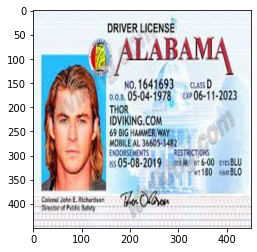

In [17]:
img_var='img008' #Change this number to other images for unit testing purposes
img_final_loc='/'+img_var+'.jpg'
trial_image_disp = Image.open(r'/content/Drivers_License_Image_Library/01_Training_Data'+img_final_loc)
plt.imshow(trial_image_disp)
plt.show()

In [18]:
labels_map = {
    0: "California",
    1: "Virginia",
    2: "Alabama",
    3: "Massachusetts",
    4: "Other"
}

In [19]:
train_loc = r'/content/Drivers_License_Image_Library/01_Training_Data/'
trainset = DataLoader(train_loc,batch_size=64, shuffle=True)

In [20]:
test_loc = r'/content/Drivers_License_Image_Library/02_Test_Data/'
testset = DataLoader(train_loc,batch_size=64, shuffle=False)

In [15]:
#os.remove(r'/content/labels.csv') #In case files need to be corrected and re-uploaded

In [21]:
from google.colab import files #Upload labels file   NOTE - labels must always be numbers/int/float for Pytorch ingestion purposes and must be labels as per indexes, starting with 0 not 1
uploaded = files.upload()

Saving labels.csv to labels.csv


In [22]:
#Setting up Driver's License Detector App variables for training specifically:
lbl_file_loc = r'/content/labels.csv'
img_file_loc = r'/content/Drivers_License_Image_Library/01_Training_Data/'

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [24]:
class DriverLicenseDetector(Dataset):        #Define Custom Dataset Class
  def __init__(self, annotations_file, img_dir, transform=True): #Generic starting function for all Python classes
    self.img_lbl = pd.read_csv(annotations_file) 
    self.img_dir = img_dir
    self.transform=transform

  def __len__(self):  #returns count of image
    return len(self.img_lbl)
  
  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_lbl.iloc[idx,0]+'.jpg')
    #print(img_path)
    img_input = np.array(read_image(img_path, mode=ImageReadMode.GRAY))    #Reading in image as grayscale using  
    #img_input = cv2.imread(img_input)
    #img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    lbl_tag = self.img_lbl.iloc[idx,1] #references self.img_lbl and label/second column from csv file per init function above
    lbl_tag_val = labels_map.get(lbl_tag) #gets value from key lbl_tag in dict type

    return img_input, lbl_tag

In [25]:
class DLNeuralNet(nn.Module):   #Define Neural Network Class
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(202500, 256) #Images are 450x450 pixels each i.e. 202,500 pixels. The 128 and 64 are random assignments to each layer of Neural network
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,5)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = DLNeuralNet()


In [26]:
train_dataset = DriverLicenseDetector(lbl_file_loc,img_file_loc) # This is just a unit test to confirm Python DLD class has been setup correctly

In [27]:
print(train_dataset[0][0].shape,train_dataset[0][1])   # This is just a unit test to confirm Python DLD class has been setup correctly

(1, 450, 450) 3


In [28]:
train_DLD_loader = DataLoader(DriverLicenseDetector(lbl_file_loc,img_file_loc),batch_size=64,shuffle=True) #This is the dataset for training Neural Network


In [ ]:
#for k,v in train_DLD_loader:  #Unit test
#  print(k,v)

In [43]:
#CPU-to-GPU - Instantiation of GPU using Pytorch and CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [44]:
#CPU-to-GPU - Transfer of model
model.to(device)

DLNeuralNet(
  (fc1): Linear(in_features=202500, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)

In [47]:
# Performing Training using Neural Network and Training Dataset

#Establishing Parameters for Learning:
num_epochs = 8  #No. of rounds to train the network

#Establishing Loss Function
criterion = nn.NLLLoss()

#Establishing Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

for i in range(num_epochs):
  cm_loss = 0
  for imags, labls in train_DLD_loader:                 #This is where the training dataset is passed through the Neural Network
    imags= imags.to(device) #CPU-to-GPU - Sending inputs to GPU
    labls= labls.to(device) #CPU-to-GPU - Sending inputs to GPU

    optimizer.zero_grad() #Zero out i.e. clean out the gradient before each pass, otherwise it will cumulate
    imags = imags.float()
    output = model(imags) # Images are loaded into NN mdel
    #print(labls)
    loss = criterion(output,labls) #comparing the output result of Neural Network to labels in csv file
    loss.backward()
    optimizer.step()
    cm_loss += loss.item()

print(f"Training loss: {cm_loss/len(train_DLD_loader)}")



Training loss: 1.6095969676971436


File Selected for testing Driver's License Detection Model is:  tstimg020.jpg
Fil's server location is:  /content/Drivers_License_Image_Library/02_Test_Data/tstimg020.jpg


Here is the predicted US State of driver's license image:  Virginia


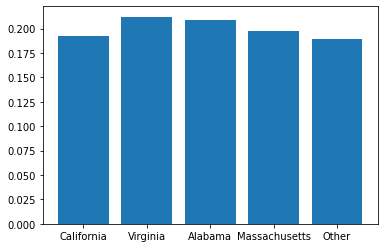



Here is the actual image:


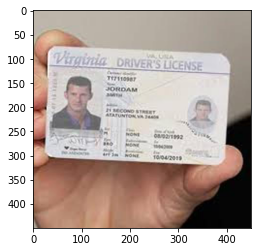

In [50]:
# Perform Testing of unseen images

#Moving model back to CPU for testing purposes
model.to('cpu')

tst_imag = random.choice(os.listdir(test_loc))
#tst_imag = 'tstimg018' + '.jpg'
print("File Selected for testing Driver's License Detection Model is: ", tst_imag)

tst_path = os.path.join(test_loc,tst_imag)
print("Fil's server location is: ", tst_path)

tst_input = read_image(tst_path, mode=ImageReadMode.GRAY)
tst_input = tst_input.float()

with torch.no_grad():
  logps=model(tst_input)

ps = torch.exp(logps)

nps = ps.numpy()[0]

print('\n')

nps_lst = list(nps)

#idx = np.where(nps==nps.max())[0]
#mp_val = int(idx[0])
#print(type(mp_val))
#mapped_val = labels_map[mp_val]

print("Here is the predicted US State of driver's license image: ", labels_map[nps_lst.index(nps.max())])


plot_lbls = list(labels_map.values())
plt.xticks(np.arange(5), labels=plot_lbls,rotation='horizontal')
plt.bar(np.arange(5),nps)
plt.show()

##### Comparison to actual image
print('\n')
print("Here is the actual image:")
tst_imag_disp = Image.open(test_loc+'/'+tst_imag)
plt.imshow(tst_imag_disp)
plt.show()
#tst_input = np.array(tst_input)